# Data Loading and Preprocessing for RNA Sequences

### Description:
### Load Data Function (load_data):
- This function takes a file path and a column name as inputs. It reads the data from the specified CSV file into a dataframe (a table-like structure in Python).
- It checks if there are any missing values in the specified column that contains RNA sequences. If missing values are found, it removes those rows from the dataframe to ensure that the analysis is done only on complete data.
### One-Hot Encoding Function (one_hot_encode):
- This function takes an RNA sequence as input. RNA sequences are made up of nucleotides represented by the letters A, C, G, and U.
- It checks if the input sequence is in the correct format (i.e., it's a string). If it’s not, the function returns None, which is a way of indicating missing or incorrect data.
- The sequence is then converted to uppercase and any occurrence of 'T' (thymine, which is found in DNA but not RNA) is replaced with 'U' (uracil, which is specific to RNA).
- The function then converts the sequence into a one-hot encoded format. This means each nucleotide (A, C, G, U) is represented as a vector (a list of numbers). For example, 
A is represented as [1, 0, 0, 0], C as [0, 1, 0, 0], G as [0, 0, 1, 0], and U as [0, 0, 0, 1]. This numerical representation is useful for computational models that require numeric input.
### Loading Specific Datasets (ENCORI and LncBase):
- The code then loads two datasets from CSV files: one called ENCORI_miRNA_lncRNA.csv and another called lncbase_with_sequences.csv. These datasets contain RNA sequences along with other biological information.
It applies the one-hot encoding function to specific columns in these datasets that contain RNA sequences. This prepares the data for further analysis or modeling, where understanding the relationships between sequences can be crucial, such as predicting RNA interactions or functions.

In [14]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam

In [15]:
import pandas as pd

def load_data(file_path, sequence_column, structure_column):
    df = pd.read_csv(file_path)
    df.dropna(subset=[sequence_column, structure_column], inplace=True)
    return df


## Step 2: One-hot Encoding of RNA Sequences
- For one-hot encoding RNA sequences, convert each nucleotide into a vector. This part of the code will also be modified to handle sequences directly without conversion, ready to be passed into an embedding layer later.

In [16]:
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'U': [0, 0, 0, 1]}
    return [mapping.get(nucleotide, [0, 0, 0, 0]) for nucleotide in sequence.upper().replace('T', 'U')]


## Step 3: Encoding Structural Information
- Structural data in dot-bracket notation needs to be encoded. We'll convert this notation into a numeric format that a neural network can process, similar to one-hot encoding.

In [17]:
def encode_structure(structure):
    structure_mapping = {'.': [1, 0, 0], '(': [0, 1, 0], ')': [0, 0, 1]}
    return [structure_mapping.get(char, [0, 0, 0]) for char in structure]


## Step 4: Preparing Data for the Model
After encoding both the sequences and their structures, the data should be prepared to ensure uniform input lengths for training. This involves padding the sequences and structures to a fixed length, which is determined by the maximum length encountered in the dataset or a predefined maximum length.

In [18]:
import numpy as np

def pad_encoded_data(encoded_data, max_length):
    padded = np.zeros((len(encoded_data), max_length, len(encoded_data[0][0])))  # Adjust the depth based on encoding
    for i, seq in enumerate(encoded_data):
        length = min(len(seq), max_length)
        padded[i, :length, :] = seq[:length]
    return padded



## Step 5: Integrating Encoded Data
Before feeding the data into the model, integrate the encoded sequence and structure data. This could mean simple concatenation along the feature axis.

In [19]:
def integrate_encodings(sequence_encodings, structure_encodings):
    # Concatenate along the last dimension (features)
    return np.concatenate((sequence_encodings, structure_encodings), axis=-1)


In [20]:
# Parameters

# Load data
mirna_df = load_data('dataset/mirna_sequences.csv', 'miRseq', 'miRseq_structure')
lncrna_df = load_data('dataset/lncbase_with_sequences.csv', 'Sequence', 'Sequence_structure')




In [21]:
# Encode data

mirna_df['encoded_sequence'] = mirna_df['miRseq'].apply(one_hot_encode)
mirna_df['encoded_structure'] = mirna_df['miRseq_structure'].apply(encode_structure)

lncrna_df['encoded_sequence'] = lncrna_df['Sequence'].apply(one_hot_encode)
lncrna_df['encoded_structure'] = lncrna_df['Sequence_structure'].apply(encode_structure)


In [22]:
# Pad data
max_length_mirna = len(mirna_df['encoded_sequence'])  # Maximum sequence length
max_length1_mirna = len(mirna_df['encoded_structure'])  # Maximum sequence length

max_length_lnc = len(lncrna_df['encoded_sequence'])  # Maximum sequence length
max_length1_lnc = len(lncrna_df['encoded_structure'])  # Maximum sequence length

mirna_df['padded_sequence'] = list(pad_encoded_data(list(mirna_df['encoded_sequence']), max_length_mirna))
mirna_df['padded_structure'] = list(pad_encoded_data(list(mirna_df['encoded_structure']), max_length1_mirna))

lncrna_df['padded_sequence'] = list(pad_encoded_data(list(lncrna_df['encoded_sequence']), max_length_lnc))
lncrna_df['padded_structure'] = list(pad_encoded_data(list(lncrna_df['encoded_structure']), max_length1_lnc))



Verify Data Shapes

In [23]:
print("Shape of miRNA sequences:", np.array(mirna_df['padded_sequence'].tolist()).shape)
print("Shape of miRNA structures:", np.array(mirna_df['padded_structure'].tolist()).shape)
print("Shape of lncRNA sequences:", np.array(lncrna_df['padded_sequence'].tolist()).shape)
print("Shape of lncRNA structures:", np.array(lncrna_df['padded_structure'].tolist()).shape)


Shape of miRNA sequences: (424, 424, 4)
Shape of miRNA structures: (424, 424, 3)
Shape of lncRNA sequences: (5671, 5671, 4)
Shape of lncRNA structures: (5671, 5671, 3)


In [24]:
# Integrate sequence and structure
mirna_df['integrated_data'] = [integrate_encodings(seq, struct) for seq, struct in zip(mirna_df['padded_sequence'], mirna_df['padded_structure'])]
lncrna_df['integrated_data'] = [integrate_encodings(seq, struct) for seq, struct in zip(lncrna_df['padded_sequence'], lncrna_df['padded_structure'])]


In [25]:
# Check the shape of the integrated data
print("Shape of integrated miRNA data:", np.array(mirna_df['integrated_data'].tolist()).shape)
print("Shape of integrated lncRNA data:", np.array(lncrna_df['integrated_data'].tolist()).shape)


Shape of integrated miRNA data: (424, 424, 7)
Shape of integrated lncRNA data: (5671, 5671, 7)


## Building Transformer Model 

In [26]:
import tensorflow as tf

def transformer_block(inputs, model_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=model_size)(inputs, inputs)
    attention = tf.keras.layers.Dropout(dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward network
    ffn = tf.keras.layers.Dense(ff_dim, activation='relu')(attention)
    ffn = tf.keras.layers.Dropout(dropout)(ffn)
    ffn = tf.keras.layers.Dense(model_size)(ffn)
    ffn = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + ffn)

    return ffn


With the preprocessed and integrated data ready, the next step is to construct the Transformer model that will use this data to predict interactions between miRNAs and lncRNAs. Here’s how you can proceed:

### Define the Model Architecture:
- Embedding Layer: Although the data is already in a form that could be input directly to the Transformer, using an embedding layer could further enhance the model's ability to capture complex patterns in the data.
- Transformer Blocks: Implement multiple Transformer blocks that will process the sequence data, utilizing self-attention mechanisms to capture both local and long-range interactions.
- Output Layer: Design the output layer to make predictions based on the processed features.

In [27]:
import tensorflow as tf

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-forward neural network
    ff = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff)

    return ff

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0.1):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model



In [28]:
# Model parameters
input_shape = (100, 7)  # 100 timesteps, 7 features per step
head_size = 64
num_heads = 4
ff_dim = 256
num_layers = 4

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 7)    │      7,943 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100, 7)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 7)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 7)    │         14 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 256)  │      2,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100, 256)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 7)    │      1,799 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 7)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 7)    │         14 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 7)    │      7,943 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 100, 7)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 7)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 7)    │         14 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100, 256)  │      2,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 100, 256)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100, 7)    │      1,799 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 100, 7)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 7)    │         14 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 47,280 (184.69 KB)

 Trainable params: 47,280 (184.69 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
mirna_df.columns

Index(['miRNAid', 'miRNAname', 'geneID', 'geneName', 'geneType', 'chromosome',
       'start', 'end', 'strand', 'clipExpNum', 'degraExpNum', 'RBP',
       'merClass', 'miRseq', 'align', 'targetSeq', 'TDMDScore', 'phyloP',
       'pancancerNum', 'miRseq_structure', 'encoded_sequence',
       'encoded_structure', 'padded_sequence', 'padded_structure',
       'integrated_data'],
      dtype='object')

# Prepare the data miRNA dataset

In [30]:
from sklearn.model_selection import train_test_split
import numpy as np



# Define a threshold to classify interactions
threshold = 10  # This threshold should be decided based on the distribution of 'clipExpNum' values

# Create a binary label column based on 'clipExpNum'
mirna_df['Interaction (Label)'] = (mirna_df['clipExpNum'] >= threshold).astype(int)

# Now you can proceed with your model training
y = mirna_df['Interaction (Label)'].values
X = np.array(mirna_df['integrated_data'].tolist())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [33]:
# Assuming you have already defined a function `build_transformer_model` to build your model
model = build_transformer_model(input_shape=(424, 7), head_size=64, num_heads=4, ff_dim=256, num_layers=4)


In [34]:
# Model training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.8627 - loss: 0.3795 - val_accuracy: 0.9412 - val_loss: 0.2263
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9148 - loss: 0.2933 - val_accuracy: 0.9412 - val_loss: 0.2265
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9129 - loss: 0.2970 - val_accuracy: 0.9412 - val_loss: 0.2259
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9093 - loss: 0.3060 - val_accuracy: 0.9412 - val_loss: 0.2296
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9188 - loss: 0.2848 - val_accuracy: 0.9412 - val_loss: 0.2259
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9317 - loss: 0.2496 - val_accuracy: 0.9412 - val_loss: 0.2292
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9053 - loss: 0.3135 - val_accuracy: 0.9412 - val_loss: 0.2301
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9034 - loss: 0.3181 - val_accuracy: 0.9412 - val_loss:

In [35]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 769ms/step - accuracy: 0.9432 - loss: 0.2229
Test Accuracy: 0.9411764740943909


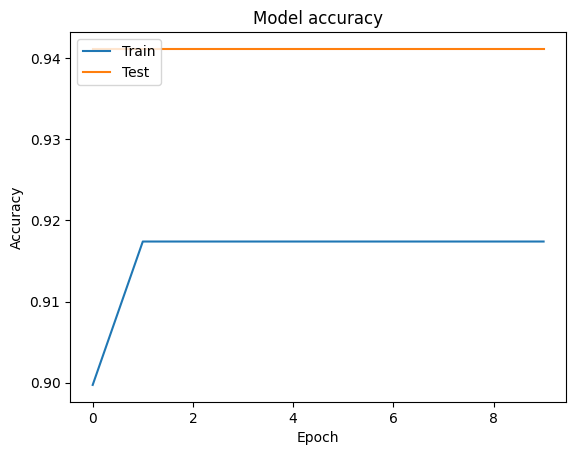

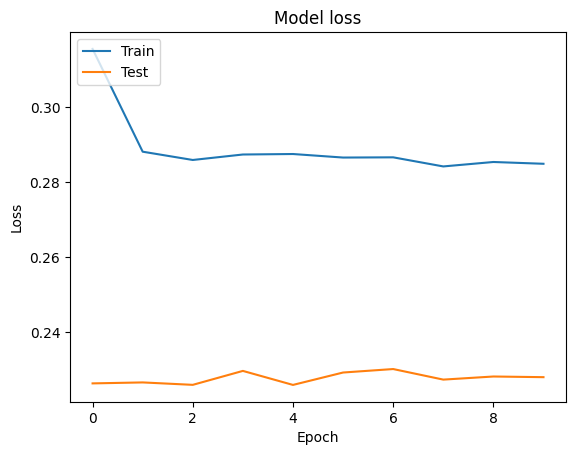

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Sequence only Model for miRNA dataset

In [38]:
# Assuming 'encoded_sequence' is already one-hot encoded
X_sequence_only = np.array(mirna_df['padded_sequence'].tolist())
y = (mirna_df['clipExpNum'] >= 10).astype(int).values  # Replace 10 with your chosen threshold

# Split the data
X_train_seq, X_test_seq, y_train, y_test = train_test_split(X_sequence_only, y, test_size=0.2, random_state=42)


In [42]:
def build_sequence_only_model(input_shape, num_layers=4, model_size=64, num_heads=4, ff_dim=256, dropout=0.1):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(model_size)(inputs)  # This dense layer projects input to the desired dimension

    for _ in range(num_layers):
        x = transformer_block(x, model_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_sequence_only = build_sequence_only_model((424, 7))


In [43]:
seqeunce_history = model_sequence_only.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9187 - loss: 0.3655 - val_accuracy: 0.9412 - val_loss: 0.2382
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9156 - loss: 0.3101 - val_accuracy: 0.9412 - val_loss: 0.2333
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9372 - loss: 0.2527 - val_accuracy: 0.9412 - val_loss: 0.2310
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9221 - loss: 0.2826 - val_accuracy: 0.9412 - val_loss: 0.2238
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9204 - loss: 0.2825 - val_accuracy: 0.9412 - val_loss: 0.2295
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9277 - loss: 0.2697 - val_accuracy: 0.9412 - val_loss: 0.2254
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9214 - loss: 0.2767 - val_accuracy: 0.9412 - val_loss: 0.2284
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9181 - loss: 0.2854 - val_accuracy: 0.9412 - val_loss:

In [44]:
test_loss, test_acc = model_sequence_only.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 905ms/step - accuracy: 0.9432 - loss: 0.2236
Test Accuracy: 0.9411764740943909


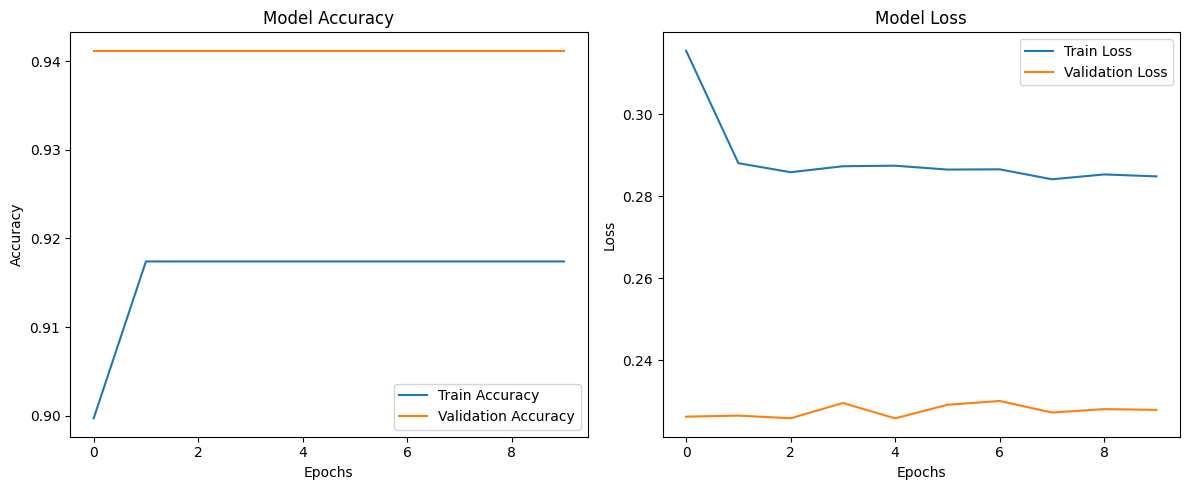

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Sequence + Structure Model 

In [46]:
X_sequence_structure = np.array(mirna_df['integrated_data'].tolist())

# Split the data
X_train_ss, X_test_ss, y_train, y_test = train_test_split(X_sequence_structure, y, test_size=0.2, random_state=42)


In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, LayerNormalization, Dropout
from tensorflow.keras.models import Model

def transformer_block(inputs, model_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=model_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention_out = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward network
    ffn = tf.keras.layers.Dense(ff_dim, activation='relu')(attention_out)
    ffn = Dropout(dropout)(ffn)
    ffn_out = tf.keras.layers.Dense(model_size)(ffn)
    ffn_out = LayerNormalization(epsilon=1e-6)(attention_out + ffn_out)

    return ffn_out



In [50]:
def build_sequence_structure_model(input_shape, num_layers=4, model_size=64, num_heads=4, ff_dim=256, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(model_size)(inputs)  # Projecting input to match model_size for the attention mechanism

    for _ in range(num_layers):
        x = transformer_block(x, model_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming you start with an input shape where the last dimension does not initially match the model_size
model_sequence_structure = build_sequence_structure_model((424, 7), model_size=64)  # Ensure correct input shape

In [51]:
history = model_sequence_structure.fit(X_train_ss, y_train, epochs=10, batch_size=32, validation_data=(X_test_ss, y_test))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8441 - loss: 0.4207 - val_accuracy: 0.9412 - val_loss: 0.2384
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9088 - loss: 0.3448 - val_accuracy: 0.9412 - val_loss: 0.2298
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9265 - loss: 0.2656 - val_accuracy: 0.9412 - val_loss: 0.2284
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9274 - loss: 0.2682 - val_accuracy: 0.9412 - val_loss: 0.2311
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9268 - loss: 0.2647 - val_accuracy: 0.9412 - val_loss: 0.2292
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9241 - loss: 0.2714 - val_accuracy: 0.9412 - val_loss: 0.2280
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9048 - loss: 0.3174 - val_accuracy: 0.9412 - val_loss: 0.2243
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9372 - loss: 0.2372 - val_accuracy: 0.9412 - val_loss:

In [52]:
test_loss, test_acc = model_sequence_structure.evaluate(X_test_ss, y_test)
print(f"Test Accuracy: {test_acc}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9432 - loss: 0.2270
Test Accuracy: 0.9411764740943909


## Structure Only Model 

In [53]:
X_structure_only = np.array(mirna_df['padded_structure'].tolist())

# Split the data
X_train_struct, X_test_struct, y_train, y_test = train_test_split(X_structure_only, y, test_size=0.2, random_state=42)


In [54]:
def transformer_block(inputs, model_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=model_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention_out = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward network
    ffn = tf.keras.layers.Dense(ff_dim, activation='relu')(attention_out)
    ffn = Dropout(dropout)(ffn)
    ffn_out = tf.keras.layers.Dense(model_size)(ffn)
    ffn_out = LayerNormalization(epsilon=1e-6)(attention_out + ffn_out)

    return ffn_out



In [55]:
def build_structure_only_model(input_shape, num_layers=4, model_size=64, num_heads=4, ff_dim=256, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = Dense(model_size)(inputs)  # Projecting input to match model_size

    for _ in range(num_layers):
        x = transformer_block(x, model_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Adjust the input shape based on your actual data preparation
model_structure_only = build_structure_only_model((424, 3))  # Assuming 100 time steps and 3 features per step


In [56]:
history_structure_only = model_structure_only.fit(X_train_struct, y_train, epochs=10, batch_size=32, validation_data=(X_test_struct, y_test))


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7058 - loss: 0.5770 - val_accuracy: 0.9412 - val_loss: 0.2395
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9231 - loss: 0.2900 - val_accuracy: 0.9412 - val_loss: 0.2580
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9194 - loss: 0.2913 - val_accuracy: 0.9412 - val_loss: 0.2238
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9177 - loss: 0.2899 - val_accuracy: 0.9412 - val_loss: 0.2275
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9252 - loss: 0.2694 - val_accuracy: 0.9412 - val_loss: 0.2285
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.9023 - loss: 0.3282 - val_accuracy: 0.9412 - val_loss: 0.2244
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9041 - loss: 0.3234 - val_accuracy: 0.9412 - val_loss: 0.2247
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.9351 - loss: 0.2407 - val_accuracy: 0.9412 - val_loss:

In [57]:
test_loss, test_acc = model_structure_only.evaluate(X_test_struct, y_test)
print(f"Test Accuracy: {test_acc}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9432 - loss: 0.2300
Test Accuracy: 0.9411764740943909


# Prepare data for lncRNA Dataset

In [58]:
lncrna_df.columns

Index(['geneId', 'geneName', 'mirna', 'species', 'cell_line', 'tissue',
       'category', 'method', 'positive_negative', 'direct_indirect',
       'condition', 'Sequence', 'Sequence_structure', 'encoded_sequence',
       'encoded_structure', 'padded_sequence', 'padded_structure',
       'integrated_data'],
      dtype='object')

In [59]:
# Finding unique characters in the structure sequences
unique_chars = set(''.join(lncrna_df['Sequence_structure'].dropna()))  # Use dropna() to avoid errors on NaN values
print("Unique characters in structure data:", unique_chars)


Unique characters in structure data: {'(', '[', ')', '.', ']'}


In [60]:
def encode_structure(structure):
    # Define a mapping for each character found in the structural data
    mapping = {
        '.': 0,  # unpaired
        '(': 1,  # paired left
        ')': 2,  # paired right
        '[': 3,  # additional characters if they exist in your data
        ']': 4,   # similarly, other characters
        '}': 5,
    
        # Add more mappings based on the output of unique_chars
    }
    # Use mapping.get to handle any unexpected characters safely
    return [mapping.get(char, -1) for char in structure]  # -1 or another number can be used for unexpected characters

# Apply this function to each structure in the DataFrame
lncrna_df['encoded_structure'] = lncrna_df['Sequence_structure'].apply(encode_structure)
lncbase_df = lncrna_df

In [61]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the encoded structures
X_structure = pad_sequences(lncbase_df['encoded_structure'].tolist(), padding='post', maxlen=max_lenght1_lnc)
X_structure = np.array(X_structure)  # Convert to a numpy array

print("Length of features:", len(X_structure))
print("Length of labels:", len(y))

NameError: name 'max_lenght1_lnc' is not defined

In [ ]:
# Assuming X_structure was previously padded but needs feature dimension
X_structure = X_structure.reshape(-1, 100, 1)  # Reshape to include feature dimension


In [ ]:
# If you are sure your data should have a third dimension
if len(X_structure.shape) == 2:  # Only batch and sequence length dimensions are present
    X_structure = np.expand_dims(X_structure, axis=-1)  # Add a singleton dimension for features

# Confirm the shape
print("Shape of X_structure after adjustment:", X_structure.shape)


In [ ]:
# Assuming that `positive_negative` might be your label column
if 'positive_negative' in lncbase_df.columns:
    y = lncbase_df['positive_negative'].apply(lambda x: 1 if x == 'positive' else 0).values
else:
    # Generate placeholder labels if actual labels are not available
    y = np.random.randint(2, size=len(X_structure))  # Make sure this matches your feature set

# Now retry the split
X_train_struct, X_test_struct, y_train, y_test = train_test_split(X_structure, y, test_size=0.2, random_state=42)


In [ ]:
print("Length of features:", len(X_structure))
print("Length of labels:", len(y))



## Structure Only Model for lncRNA

In [ ]:
model_size = 64  # Reduced for simplicity and divisibility
num_heads = 4    # This should divide model_size evenly

# Ensure model_size is divisible by num_heads
assert model_size % num_heads == 0, "model_size must be divisible by num_heads"


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, LayerNormalization, Dropout, TimeDistributed
from tensorflow.keras.models import Model

def transformer_block(inputs, model_size, num_heads, ff_dim, dropout=0.1):
    attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=model_size)
    attention_output = attention_layer(inputs, inputs)
    attention_output = tf.keras.layers.Dropout(dropout)(attention_output)
    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    print("After Attention:", attention_output.shape)

    # Feed-forward network, ensure output size matches model_size
    ffn = tf.keras.layers.Dense(ff_dim, activation='relu')(attention_output)
    ffn = tf.keras.layers.Dropout(dropout)(ffn)
    ffn_output = tf.keras.layers.Dense(model_size)(ffn)
    ffn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ffn_output)
    print("After FFN:", ffn_output.shape)

    # Explicitly ensuring dimensions match before adding
    if ffn_output.shape[-1] != attention_output.shape[-1]:
        ffn_output = tf.keras.layers.Dense(attention_output.shape[-1])(ffn_output)

    # Using Add layer to combine
    combined_output = tf.keras.layers.Add()([attention_output, ffn_output])
    final_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(combined_output)
    print("After Add and Normalize:", final_output.shape)

    return final_output




In [ ]:
def build_structure_only_model(input_shape=(100, 3), num_layers=4, model_size=64, num_heads=4, ff_dim=256, dropout=0.1):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_layers):
        x = transformer_block(x, model_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ensure the model is built with the correct input shape
model_structure_only = build_structure_only_model(input_shape=(100, 3))


In [ ]:
print("Data shape:", X_train_struct.shape)
print("Model input spec:", model_structure_only.input_shape)


In [ ]:
# Placeholder function to expand or calculate additional features
def expand_features(data):
    # Assuming data is (batch, timesteps, 1)
    # Expand or calculate two additional features here
    new_feature1 = np.random.random(data.shape)  # Placeholder for actual feature calculation
    new_feature2 = np.random.random(data.shape)  # Placeholder for actual feature calculation
    return np.concatenate([data, new_feature1, new_feature2], axis=-1)

# Apply feature expansion
X_structure = expand_features(X_structure)

# Check the new shape
print("New shape of X_structure:", X_structure.shape)


In [ ]:
# print("Model input spec after adjustment:", model_structure_only.input_shape)
# model_structure_only.summary()


In [ ]:
# Verify the final input shape
print("Final shape of X_structure:", X_structure.shape)

# Split the data again if necessary
X_train_struct, X_test_struct, y_train, y_test = train_test_split(X_structure, y, test_size=0.2, random_state=42)
history = model_structure_only.fit(
    X_train_struct, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_struct, y_test)
)


# Sequence Only Model

## Validate sequence data preparation 

In [ ]:
# Check the shape and type of the sequence data
print("Shape of padded_sequence:", lncbase_df['padded_sequence'].shape)
print("Sample data:", lncbase_df['padded_sequence'].iloc[0])


In [ ]:
def build_sequence_only_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(256, 5, activation='relu', padding='same'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming the padded sequences are correctly formatted as NumPy arrays
X = np.array(list(lncbase_df['padded_sequence']))  # Convert column to array if it's not already
y = lncbase_df['category'].apply(lambda x: 1 if x == 'positive' else 0).values  # Example binary classification

# Build the model with the input shape based on your data
model_seq_only = build_sequence_only_model((X.shape[1], X.shape[2]))

# Now the model is built with convolutional layers only, avoiding the use of LSTM.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model_seq_only.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)


In [ ]:
evaluation = model_seq_only.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


# Sequence + Structure Model

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'encoded_sequence' and 'encoded_structure' are lists of lists where inner lists might have variable lengths
sequence_lengths = [len(seq) for seq in lncbase_df['encoded_sequence']]
structure_lengths = [len(struct) for struct in lncbase_df['encoded_structure']]

# Decide on a fixed length for padding based on your data's distribution or a set maximum
max_seq_length = max(sequence_lengths)
max_struct_length = max(structure_lengths)

# Pad both sequences and structures to have the same length
X_sequences_padded = pad_sequences(lncbase_df['encoded_sequence'], maxlen=max_seq_length, padding='post', dtype='int32')
X_structures_padded = pad_sequences(lncbase_df['encoded_structure'], maxlen=max_struct_length, padding='post', dtype='int32')

print("Shape of X_sequences_padded:", X_sequences_padded.shape)
print("Shape of X_structures_padded:", X_structures_padded.shape)



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example of padding if 'encoded_sequence' and 'encoded_structure' are lists of integers
X_sequences_padded = pad_sequences(lncbase_df['encoded_sequence'], maxlen=max_seq_length, padding='post', dtype='int32')
X_structures_padded = pad_sequences(lncbase_df['encoded_structure'], maxlen=max_seq_length, padding='post', dtype='int32')

# Ensure both are 2-dimensional and padded to the same length
print("Rechecked Shape of X_sequences_padded:", X_sequences_padded.shape)
print("Rechecked Shape of X_structures_padded:", X_structures_padded.shape)


In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense

def transformer_encoder(inputs, model_size, num_heads, ff_dim, dropout_rate):
    # Multi-head self-attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=model_size)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward network
    outputs = Dense(ff_dim, activation='relu')(attention)
    outputs = Dense(model_size)(outputs)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = LayerNormalization(epsilon=1e-6)(attention + outputs)

    return outputs

def build_transformer_model(input_shape, model_size=64, num_heads=4, ff_dim=128, dropout_rate=0.1, num_layers=2):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_layers):
        x = transformer_encoder(x, model_size, num_heads, ff_dim, dropout_rate)

    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Use this model to build with the correct input shape
model_seq_struct = build_transformer_model((X_combined.shape[1], X_combined.shape[2]))


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'category' column is your target and you need to convert it to a binary format
y = lncbase_df['category'].apply(lambda x: 1 if x == 'positive' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

history = model_seq_struct.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test)
)
